In [1]:
from tqdm.notebook import tqdm
from darts.models import LinearRegressionModel
import pickle


In [2]:
import pickle


with open("/path/to/pklFiles/low_series_dict.pkl","rb") as file:
    target_series_dict=pickle.load(file)

In [3]:
import numpy as np

train_target_dict = {}
test_target_dict = {}
all_ids = []


for i_id in  (target_series_dict.keys()):
    full_target_series, covariates = target_series_dict[i_id]
    all_ids.append(i_id)
    train_target, test_target = full_target_series[:-28], full_target_series[-28:]

    # --- CAST HERE to float32 ---
    train_target = train_target.astype(np.float32)
    test_target = test_target.astype(np.float32)

    train_target_dict[i_id] = train_target
    test_target_dict[i_id] = test_target



print(f"Number of series: {len(all_ids)}")
print(f"Example training series length: {train_target_dict['CA_1_FOODS_1_001'].n_timesteps}")
print(f"Example test series length: {test_target_dict['CA_1_FOODS_1_001'].n_timesteps}")

Number of series: 30490
Example training series length: 1941
Example test series length: 28


In [ ]:


forecasts_dict = {}
for i_id in tqdm(target_series_dict.keys(), total=len(target_series_dict.keys()), desc="Forecasting series"):
    
    model = LinearRegressionModel(
        lags=28,
        use_static_covariates=False
    )
    model.fit(train_target_dict[i_id])

    forecast = model.predict(n=28)
    
    # Store the forecast
    forecasts_dict[i_id] = forecast

In [4]:
import pickle


with open("/path/to/BasicModels/LinearRegression/forecasts_dict.pkl","rb") as file:
    forecast_dict=pickle.load(file)

# Evaluation

In [5]:
import pandas as pd 
weights_df = pd.read_csv("/path/to/ExtraFiles/weights_validation.csv")

# We only want rows for Level12
weights_df = weights_df[weights_df["Level_id"] == "Level12"].copy()

# Create a new 'id' column by combining Agg_Level_1 and Agg_Level_2
weights_df["id"] =weights_df["Agg_Level_2"] + "_" + weights_df["Agg_Level_1"] 


weights_df = weights_df.sort_values(['id'])
# Build a dictionary: {id_string: weight_value}
weights_map = dict(zip(weights_df["id"], weights_df["weight"]))

In [6]:
from darts.metrics import rmse,mae,rmsse
wrmsse_list = []

for i_id in all_ids:
    weight_value = weights_map[i_id]
    wrmsse_value = weight_value*rmsse(actual_series=test_target_dict[i_id],pred_series=forecast_dict[i_id], insample=train_target_dict[i_id])
    wrmsse_list.append(wrmsse_value)

In [7]:
print(f"WRMSSE = {sum(wrmsse_list)}")

WRMSSE = 0.9138545112084677


In [8]:
rmse_list = []
mae_list = []
for i_id in all_ids:
    forecast = forecast_dict[i_id]
    val_series = test_target_dict[i_id]

    error_rmse = rmse(val_series, forecast)
    error_mae = mae(val_series,forecast)
    rmse_list.append(error_rmse)
    mae_list.append(error_mae)

mean_rmse = np.mean(rmse_list)
mean_mae = np.mean(mae_list)

# Print the mean RMSE
print(f"\nMean RMSE across all series: {mean_rmse:.3f}")
print(f"\nMean MAE across all series: {mean_mae:.3f}")


Mean RMSE across all series: 1.468

Mean MAE across all series: 1.142


In [9]:
metrics_df = pd.DataFrame({
    'id': all_ids,
    'RMSE': rmse_list,
    'MAE': mae_list,
    'WRMSSE': wrmsse_list
})


In [11]:
output_path = '/path/to/RMSE_MAE/metrics_df_linear.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(metrics_df, f)

In [12]:
print(f"Number of RMSE's above 10 -> {(metrics_df['RMSE'] > 10).sum()}")

Number of RMSE's above 10 -> 294


In [13]:
# Determine the number of top 10% elements
top_10_percent_count = int(len(metrics_df) * 0.10)

# Sort RMSE values in descending order and take the top 10%
top_10_percent_rmse_sum = metrics_df['RMSE'].nlargest(top_10_percent_count).sum()

print(top_10_percent_rmse_sum)


17321.443


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

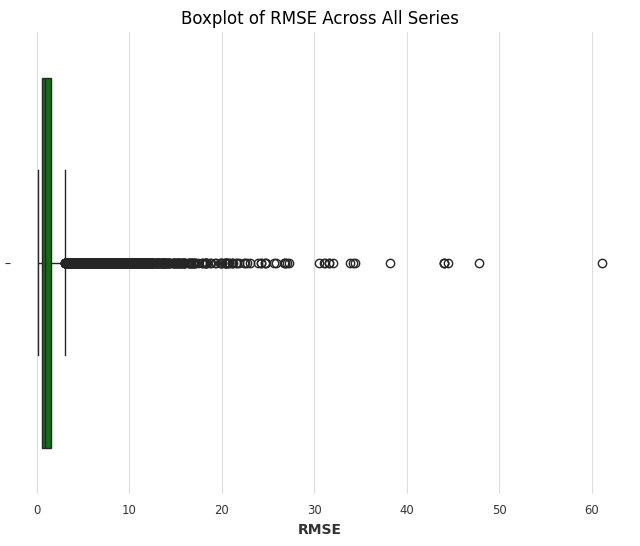

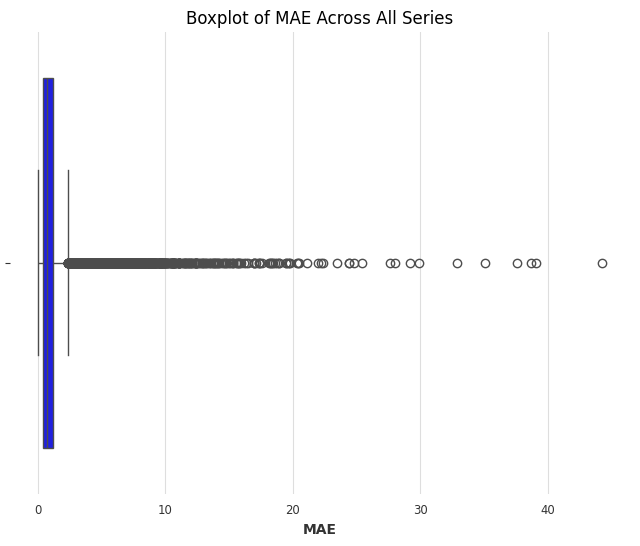

In [15]:
# Plot a boxplot of RMSE values
plt.figure(figsize=(8, 6))
sns.boxplot(x=metrics_df['RMSE'], color='green')
plt.title('Boxplot of RMSE Across All Series')
plt.xlabel('RMSE')
plt.show()

# Plot a boxplot of RMSE values
plt.figure(figsize=(8, 6))
sns.boxplot(x=metrics_df['MAE'], color='blue')
plt.title('Boxplot of MAE Across All Series')
plt.xlabel('MAE')
plt.show()


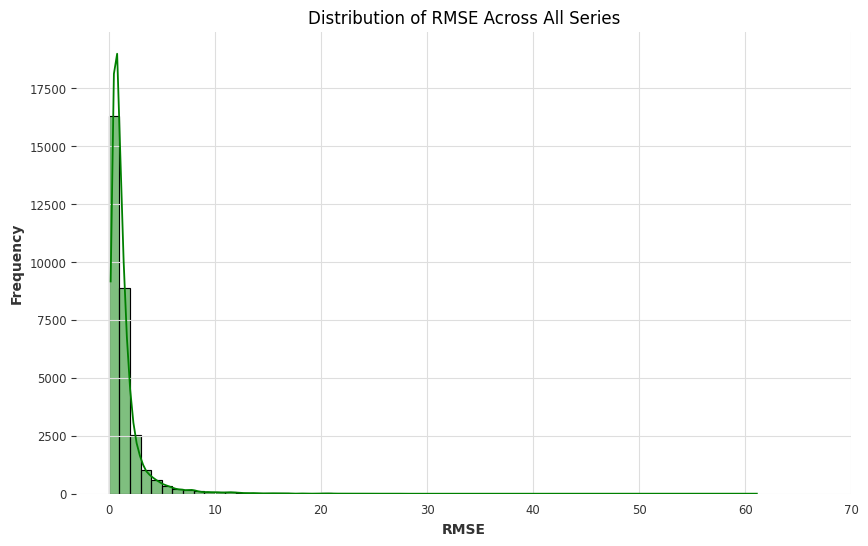

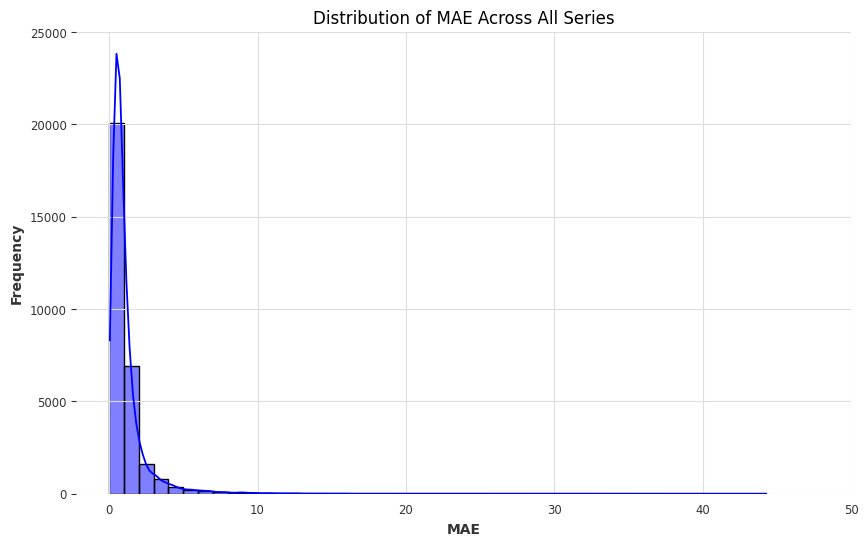

In [16]:
# Define bin width and range for x-axis ticks
bin_width = 1  # Each bar represents a width of 1
x_min = int(metrics_df['RMSE'].min())  # Round to the nearest integer
x_max = int(metrics_df['RMSE'].max())  # Round to the nearest integer
bins = np.arange(x_min, x_max + bin_width, bin_width)  # Ensure each bin is of width 1
  # Set x-axis ticks with increments of 10
x_ticks = np.arange(0, x_max + 10, 10)
# Plot a histogram of RMSE values
plt.figure(figsize=(10, 6))
sns.histplot(metrics_df['RMSE'], bins=bins, kde=True, color='green')

# Set title and labels
plt.title('Distribution of RMSE Across All Series')
plt.xlabel('RMSE')
plt.ylabel('Frequency')

# Set x-axis tick increments
plt.xticks(x_ticks)

plt.show()



# Define bin width and range for x-axis ticks
bin_width = 1  # Each bar represents a width of 1
x_min = int(metrics_df['MAE'].min())  # Round to the nearest integer
x_max = int(metrics_df['MAE'].max())  # Round to the nearest integer
bins = np.arange(x_min, x_max + bin_width, bin_width)  # Ensure each bin is of width 1
  # Set x-axis ticks with increments of 10
x_ticks = np.arange(0, x_max + 10, 10)
# Plot a histogram of RMSE values
plt.figure(figsize=(10, 6))
sns.histplot(metrics_df['MAE'], bins=bins, kde=True, color='blue')

# Set title and labels
plt.title('Distribution of MAE Across All Series')
plt.xlabel('MAE')
plt.ylabel('Frequency')

# Set x-axis tick increments
plt.xticks(x_ticks)

plt.show()